In [1]:
from coffea import hist, util

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot

from pprint import pprint

import matplotlib.pyplot as plt

## Z boson selector

In [2]:
class Zselector(processor.ProcessorABC):
    def __init__(self):
        ### This function is where the histograms are defined and any other initialization happens
        
        ### Muon pt
        #Declare an axis for the dataset
        dataset_axis = hist.Cat("dataset","Dataset")
        
        #Declare an axis for the muon pt
        pt_axis = hist.Bin("pt","$p_T$ [Gev]", 40, 0, 200)
        eta_axis = hist.Bin("eta","$\eta$", 50, 0, 2.5)
        phi_axis = hist.Bin("phi","$\phi$", 50, 0, 3.5)
        mass_axis = hist.Bin("mass","Mass [GeV]", 200, 50, 150)
        r_axis = hist.Bin("r",r"$\Delta R$", 50, 0, 4)

        
        #Define the accumulator object, a dictionary storing all of the histograms and counters 
        #that we will fill later in the process function
        self._accumulator = processor.dict_accumulator({
            'leading_muon_pt': hist.Hist("Counts", dataset_axis, pt_axis),
            
            'muon_total_mass': hist.Hist("Counts", dataset_axis, mass_axis),
            
            'muon_eta_difference': hist.Hist("Counts", dataset_axis, eta_axis),
            'muon_phi_difference': hist.Hist("Counts", dataset_axis, phi_axis),
            'muon_R_difference': hist.Hist("Counts", dataset_axis, r_axis),
            
        }
        )

        
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        ### The process function is where most of the work happens. As we'll see below, this is
        ### where the main analysis work happens (object cuts, event selections, filling histograms). 
        
        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()

        ## To access variables from the ntuples, use the "events" object
        ## The dataset name is part of events.metadata
        dataset = events.metadata['dataset']
        
        
        # ----------------------------------------------------------------------------
        
        muons = events.Muon
        
        # Select tight muons
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # Select exactly two muons
        muonSelectTwo = (ak.num(tightMuons)==2)
        twoMuons = tightMuons[muonSelectTwo]
        
        
        # select events with exactly two oppositely charged muons
        eventSelection = ((twoMuons.charge[:,0] + twoMuons.charge[:,1])==0)
        
        
        # Fill the muon_pt histogram using the tightMuons in events that pass our selection 
        # Note that ak.flatten() is required when filling a histogram to remove the jaggedness
        output['leading_muon_pt'].fill(dataset=dataset,
                                       pt=ak.flatten(twoMuons[eventSelection][:,:1].pt))
        
        
        # call .mass on the *sum* of the muons
        output['muon_total_mass'].fill(dataset=dataset,
                                      mass=ak.flatten(twoMuons[eventSelection][:,:1] + twoMuons[eventSelection][:,1:]).mass )
        
        output['muon_eta_difference'].fill(dataset=dataset,
                                           eta=ak.flatten(abs(twoMuons[eventSelection][:,:1].eta - twoMuons[eventSelection][:,1:].eta)) )
        output['muon_phi_difference'].fill(dataset=dataset,
                                      phi=ak.flatten(abs(twoMuons[eventSelection][:,:1].delta_phi(twoMuons[eventSelection][:,1:]))) )
        output['muon_R_difference'].fill(dataset=dataset,
                                      r=ak.flatten(twoMuons[eventSelection][:,:1].delta_r(twoMuons[eventSelection][:,1:])) )
        
        # ----------------------------------------------------------------------------
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
           "WGamma":[f"{skimDir}/WGamma_2016_skim.root"],
           "Z+jets":[f'{skimDir}/DYjetsM50_ext2_2016_skim_1of10.root'],
           "W+3jets":[f"{skimDir}/W3jets_2016_skim.root"],
           "W+4jets":[f"{skimDir}/W4jets_2016_skim.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }


In [4]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)
        
#Run Coffea code using uproot
outputMC_Z = processor.run_uproot_job(
    fileset,  #dictionary of datasets to run on, defined earlier in this cell
    "Events", #Name of the TTree you will be opening
    Zselector(),  #Coffea processor you defined
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  ## workers = 2, parallelize jobs, running 2 at once
    chunksize=1000000, #in each chunk, use 1 million events
#     maxchunks=1, #limit to using only 3 chunks for each dataset (useful for testing purposes)
)


Preprocessing:   0%|          | 0/7 [00:00<?, ?file/s]

Processing:   0%|          | 0/23 [00:00<?, ?chunk/s]

In [5]:
outputData_Z = processor.run_uproot_job(
    filesetData, 
    "Events", 
    Zselector(), 
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  
    chunksize=1000000, 
)

data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

In [6]:
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]
pprint(nEvents)


{'TTGamma': 11005200.0,
 'TTbar': 17673700.0,
 'W+3jets': 19798117.0,
 'W+4jets': 9116657.0,
 'WGamma': 6103817.0,
 'Z+jets': 8920292.0}


In [7]:
cx = {'TTGamma':7.509,
     'TTbar': 380.095,
     'WGamma':489,
     'Z+jets':6077.22,
     'W+3jets':1165.8108,
     'W+4jets':592.9176}
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName] # Luminosity 450 instead of 578
    
pprint(lumi_weight)


{'TTGamma': 0.0003070412168792934,
 'TTbar': 0.009677812229470908,
 'W+3jets': 0.02649822000748859,
 'W+4jets': 0.02926653048370691,
 'WGamma': 0.03605121188921621,
 'Z+jets': 0.3065761748606436}


In [8]:
#Scale histograms
for key, obj in outputMC_Z.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")


### Leading muon $p_T$

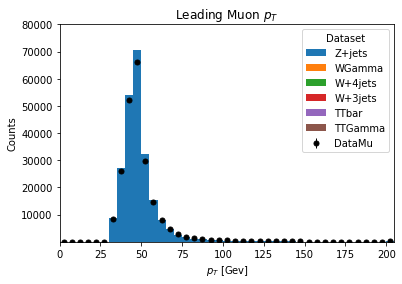

In [9]:
hist.plot1d(outputData_Z['leading_muon_pt'],overlay='dataset',error_opts=data_err_opts,overflow='over')
hist.plot1d(outputMC_Z['leading_muon_pt'],overlay='dataset',stack=True,overflow='over')
plt.title('Leading Muon $p_T$')
plt.ylim(0.1,80000)
plt.show()


### Z boson mass by addition of muons

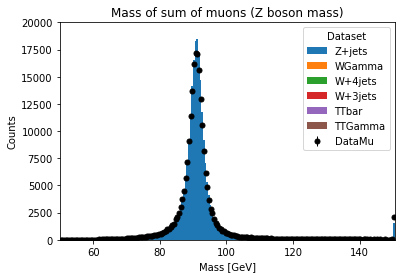

In [10]:
hist.plot1d(outputData_Z['muon_total_mass'],overlay='dataset',error_opts=data_err_opts,overflow='over')
hist.plot1d(outputMC_Z['muon_total_mass'],overlay='dataset',stack=True,overflow='over')
plt.title('Mass of sum of muons (Z boson mass)')
plt.ylim(0,20000)
plt.show()


### Difference in $\eta$

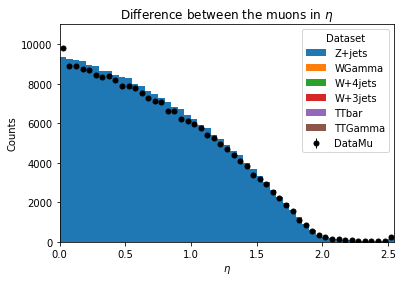

In [11]:
hist.plot1d(outputData_Z['muon_eta_difference'],overlay='dataset',error_opts=data_err_opts,overflow='over')
hist.plot1d(outputMC_Z['muon_eta_difference'],overlay='dataset',stack=True,overflow='over')
plt.title('Difference between the muons in $\eta$')
plt.ylim(0,11000)
plt.show()


### Difference in $\phi$

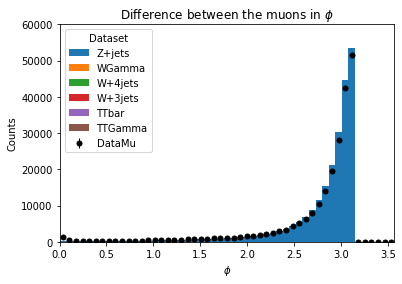

In [12]:
hist.plot1d(outputData_Z['muon_phi_difference'],overlay='dataset',error_opts=data_err_opts,overflow='over')
hist.plot1d(outputMC_Z['muon_phi_difference'],overlay='dataset',stack=True,overflow='over')
plt.title('Difference between the muons in $\phi$')
plt.ylim(0,60000)
plt.show()


### Difference in R: $\Delta R = \sqrt{\Delta\eta^2 + \Delta\phi^2}$

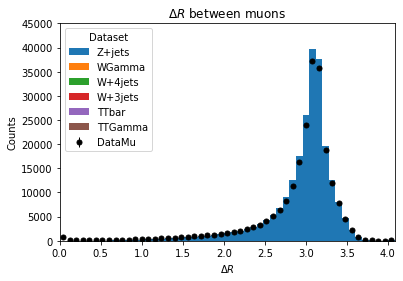

In [13]:
hist.plot1d(outputData_Z['muon_R_difference'],overlay='dataset',error_opts=data_err_opts,overflow='over')
hist.plot1d(outputMC_Z['muon_R_difference'],overlay='dataset',stack=True,overflow='over')
plt.title('$\Delta R$ between muons')
plt.ylim(0,45000)
plt.show()


# Fitting distributions to the histograms

In [14]:
from scipy.optimize import curve_fit

Try fitting the Z boson mass histogram to a Gaussian distribution using the `curve_fit` function from `scipy`: __[curve_fit documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)__.

Gaussian distribution function: $f(x; A, \mu, \sigma) = \frac{A}{\sigma\sqrt{2\pi}}e^{\left[ -(x-\mu)^2/2\sigma^2 \right]}$, where $A$ is the amplitude of the curve (necessary for curves that aren't normalized), $\mu$ is the mean, and $\sigma$ is the standard deviation.

In [15]:
# Define the model function
def gaussian(x, amp, mu, sigma):
    return (amp/(sigma*np.sqrt(2*np.pi)))*np.exp((-1/2)*(((x - mu)/sigma)**2))

In [16]:
# Array for x (mass) values. Matches the binning defined in the processor.
x = np.linspace(50,150,200)

# m_dat = heights of each bin in the histogram (y values)
# m_errSquared = squares of errors in the data points.
#       Setting `sumw2=True` gives us this second array along with the data array.
data, errSquared = outputMC_Z['muon_total_mass'].sum('dataset').values(sumw2=True)[()]


###
# Call `curve_fit` using the model function, x vals, y vals.
# optional params: p0 = inital guesses for parameters, sigma = errors in the data values.
# Returns: paramater array, covariance matrix of parameters.
G_param, G_cov = curve_fit(gaussian, x, data, p0=(1,90,1), sigma=np.sqrt(errSquared))


Plot the histogram & gaussian fit together:

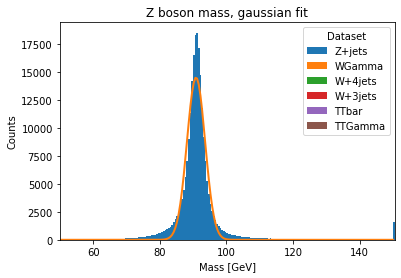

In [17]:
hist.plot1d(outputMC_Z['muon_total_mass'],overlay='dataset',stack=True,overflow='over')
plt.plot(x, gaussian(x, *G_param),color="tab:orange",linewidth=2)
plt.title('Z boson mass, gaussian fit')
plt.show()

The `curve_fit` function returns two arrays:
1. `G_param`, an array of values for the parameters defined in the model function; in our case, `amp`, `mu`, and`sigma`
2. `G_cov`, the covariance matrix for the parameters. 

In [18]:
G_param # array of parameter values: amp, mu, sigma

array([9.89396411e+04, 9.08894101e+01, 2.72096895e+00])

In [19]:
print('Amplitude: ', G_param[0])
print('Mean:      ', G_param[1]) # Z boson mass
print('Std dev:   ', G_param[2])

Amplitude:  98939.64113172307
Mean:       90.88941006490703
Std dev:    2.7209689535251966


In [20]:
G_cov # covariance matrix

array([[ 8.29163240e+06,  1.08916148e-03, -8.59317958e-03],
       [ 1.08916147e-03,  6.28262355e-03, -2.34516732e-04],
       [-8.59317889e-03, -2.34516732e-04,  4.76487730e-03]])

The diagonal entries of the covariance matrix are the squares of the uncertainties in each parameter:

In [21]:
np.sqrt(np.diag(G_cov)) # uncertainties in amp, mu, sigma

array([2.87951947e+03, 7.92630024e-02, 6.90280907e-02])

The Gaussian distribution doesn't fit the data well, even by eye. Instead of a Gaussian distribution, we can try a Lorentzian distribution:

$f(x; A, \mu, \sigma) = \frac{A}{\pi} \left[ \frac{\sigma}{(x-\mu)^2 + \sigma^2} \right]$

In [22]:
# Define the model function
def lorentzian (x, amp, mu, sig):
    return ( (amp/np.pi)*(sig / ((x - mu)**2 + sig**2)) )

In [23]:
# Call `curve_fit` using the lorentzian function
L_param, L_cov = curve_fit(lorentzian, x, data, p0=(1,90,1), sigma=np.sqrt(errSquared))


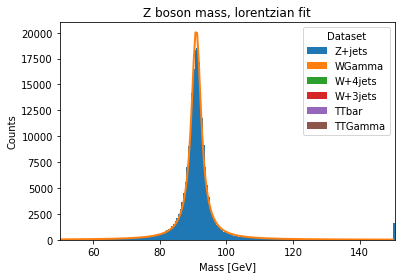

In [24]:
# Plot the fit with the histogram
hist.plot1d(outputMC_Z['muon_total_mass'],overlay='dataset',stack=True,overflow='over')
plt.plot(x, lorentzian(x, *L_param),color="tab:orange",linewidth=2)
plt.title('Z boson mass, lorentzian fit')
plt.ylim(0,21000)
plt.show()

In [25]:
# Get statistics from parameter array & covariance matrix
L_param_err = np.sqrt(np.diag(L_cov))

print('Amplitude: ', L_param[0], '    Error: ', L_param_err[0])
print('Mean:      ', L_param[1], '     Error: ', L_param_err[1])
print('Std dev:   ', L_param[2], '    Error: ', L_param_err[2])

Amplitude:  114028.59563969224     Error:  1552.6509702012058
Mean:       90.94586257946844      Error:  0.03522503973241664
Std dev:    1.7788872189054472     Error:  0.03335448182100682


## Chi-squared analysis
The chi-squared value is the sum over all data points of the residual between the expected (fitted) value and the actual data point, divided by the error in that data point, the whole term squared: $\chi^2 = \sum\left(\frac{ \text{fit} - \text{data}}{{\sigma_\text{data}}}\right)^2$.

The reduced chi-squared value is the ratio of the chi-squared value to the number of degrees of freedom of the fitted curve, $\chi^2_\text{reduced} = \frac{\chi^2}{\text{d.f.}}$. The number of degrees of freedom of the curve is the difference between the number of data points and the number of fitted parameters.

For a good fit, the chi-squared value should be approximately equal to the number of data points (the difference between the each fitted point and data point should be equal to the error in the data point), so the *reduced* chi-squared value should be approximately equal to 1.

In [26]:
# Arrays of fitted points (used e.g. in the plotting functions)
G_fit = gaussian(x, *G_param) # gaussian fit
L_fit = lorentzian(x, *L_param) # lorentzian fit

# chi^2
G_chiSquared = sum( (G_fit - data)**2 / errSquared )
L_chiSquared = sum( (L_fit - data)**2 / errSquared )

# reduced chi^2
dof = np.size(data) - np.size(G_param) # num data points (200 bins) - num parameters (3; amp, mu, sigma)
G_reducedChiSquared = G_chiSquared / dof
L_reducedChiSquared = L_chiSquared / dof


print('Gaussian fit.')
print('chi^2: ', G_chiSquared)
print('reduced chi^2: ', G_reducedChiSquared)
print('\nLorentzian fit.')
print('chi^2: ', L_chiSquared)
print('reduced chi^2: ', L_reducedChiSquared)

Gaussian fit.
chi^2:  107166.14967219492
reduced chi^2:  543.9906074730707

Lorentzian fit.
chi^2:  26379.859958403937
reduced chi^2:  133.90791857057835


The reduced chi-squared values for the Lorentzian fit are lower than for the Gaussian fit, so the Lorentzian is a better fit. However, the reduced chi-squared value is much greater than 1, so the fit is still not very good.